In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from geopy import distance
import geopandas
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
import keras 

#from keras.models import Sequential
from keras import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
#from keras.utils import np_utils
from keras import utils as np_utils
from sklearn.metrics import confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
#from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
#Note - you might need to adjust things to balance the load on the 
#machine. 
# Results vary pretty widely based on the choices. 
test_split = True
split_num = 200000
epochs = 20
ID_cust = False
ID_job = False
ID_merch = False
batch_size = 256
ratio_sample = .1
cb_epochs = 20
flat_layer_size = 512

drop_ratio = .15
reg_ratio = .15

# Assignment 4 - Simple Neural Networks

For this assigment you'll do a realistic task - predicting fraud from transaction data. 
### Some Things to Note

<ul>
<li> The dataset is imbalanced. See: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data for some ideas
<li> The locations, time, dob all likely aren't super useful on their own, but can be made into something more useful without much code or trouble. Think about how it may be useful to represent them. The data doesn't have missing rows, so this is the main data prep portion. 
<li> With respect to the above, and the other data here, we have a lot of rows of data. That means that we can generally handle data that is reasonably wide...
</ul>

### Deliverables

Your final goal is to produce a function that can be called to classify a transaction:
<ul>
<li> Please submit two .ipynb files - one where you did your work, and another that can use your model to make predictions. 
<li> In that prediction file, please ensure:
    <ul>
    <li> You have a function where I can load a file, and the end result is a classificaiton matrix of your prediction accuracy. 
    <li> You load a trained model. There's no training here. 
    <li> Any data prep stuff that is needed for your data should be built in here. I'm going to run a test file that is the exact same setup as the training data.
    <li> I should be able to open the prediction file, load the test data, and click RUN ALL and things should work. 
    <li> In addition to that, please include a short (~1-2 paragraph) description of what you did. Include anything that was innovative/different as well as a note on:
        <ul>
        <li> Any imbalanced data steps. 
        <li> Treatment of the location and time variables. What did you do to them?
        <li> Model structure (layers/size)
        <li> Any optimization steps included - regularization, dropouts, feature selection, etc...
        </ul>
    </ul>
</ul>

### Grades

The grade breakdown is as follows:

<ul>
<li> Code preduces predictions - 40
<li> Accuracy - 30
<li> Explaination - 20
<li> Balance/variable transformations - 10
</ul>



## Sample Solution Performance Notes

I didn't spend ages trying to make this as accurate as possible, but I did try a few variations of some options:
<ul>
<li> A few different model structures - number of layers and widths. </li>
<li> Manipulating some of the variables in different ways. </li>
<li> I did some testing with imbalanced approaches of weights and bias. </li>
</ul>

Overall, this isn't super easy to nail accurately, or it at least requires either some luck or some time allocated to searching. 

Some things I noticed were:
<ul>
<li> The imbalanced approaches tended to make the recall better, meaning that the model was better at finding the fraud cases. Accuracy was generally lower, but that's because the model was more likely to predict fraud. </li>
<li> In some trials that ran for longer, I noticed a few times with very distinct local minima in training, where the loss dropped and jumped back up. This is an indication that the model may find a better outcome if we let it run for a while - I'd also try some other options on teh optimizer to see if we can get better performance that way. </li>
</ul>


In [2]:
import os

file_path = "fraudTrain.csv.zip"

if not os.path.exists(file_path):
    file_path = keras.utils.get_file("fraudTrain.csv.zip", "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/fraudTrain.csv.zip")

df = pd.read_csv(file_path)
df.drop(columns={"Unnamed: 0"}, inplace=True)
df.head()

 55779328/139194466 ━━━━━━━━━━━━━━━━━━━━ 3:53 3us/step

KeyboardInterrupt: 

In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
trans_date_trans_time,1296675,1274791,2019-04-22 16:02:01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc_num,1296675.0,NaN,NaN,NaN,417192042079726656.0,1308806447000789248.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0
merchant,1296675,693,fraud_Kilback LLC,4403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,1296675,14,gas_transport,131659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amt,1296675.0,NaN,NaN,NaN,70.351035,160.316039,1.0,9.65,47.52,83.14,28948.9
first,1296675,352,Christopher,26669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,1296675,481,Smith,28794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,1296675,2,F,709863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
street,1296675,983,0069 Robin Brooks Apt. 695,3123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1296675,894,Birmingham,5617,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Deal with Lat/Lon

We can calculate the distance between home and merchant. Maybe this is a useful factor?

In [ ]:
geometry_home = geopandas.points_from_xy(df["long"], df["lat"])
geometry_tran = geopandas.points_from_xy(df["merch_long"], df["merch_lat"])
df["dist_from_home"] = geometry_home.distance(geometry_tran)
#tmp_home = (df["lat"], df["long"])
#tmp_merch = (df["merch_lat"], df["merch_long"])
#tmp_home
#df["dist_from_home"] = distance.distance(tmp_home, tmp_merch)
df["dist_from_home"].head()


0    0.872830
1    0.272310
2    0.975845
3    0.919802
4    0.868505
Name: dist_from_home, dtype: float64

### Deal with Time

Get the hour of the day, the time since last transaction, and the age of the customer. 

In [ ]:
df["Time"] = pd.to_datetime(df["trans_date_trans_time"]).dt.hour

In [ ]:
df["recency"] = df.groupby(by="cc_num")["unix_time"].diff()/3600
df.loc[df.recency.isnull(),["recency"]] = -1
df["recency"].sample(10)

215983      9.488056
105773      0.954167
1184796     7.882778
243442      3.603889
750259      0.827500
1114266    21.703611
405682      2.476944
34901       3.021944
630689      1.648056
1279746     0.139444
Name: recency, dtype: float64

In [ ]:
df["year_born"] = pd.to_datetime(df["dob"]).dt.year
df["year_born"].sample(10)

1113277    1989
286329     1975
413507     1956
929788     1972
635280     1955
52807      1965
728089     1976
204239     1949
459798     1930
779736     1945
Name: year_born, dtype: int32

### Clear out Old Stuff

In [ ]:
#df = df.drop(columns={"trans_date_trans_time", "dob", "trans_num", "merchant", "first", "last", "street", "city", "zip", "lat", "job", "long", "merch_lat", "merch_long", "trans_date_trans_time", "unix_time"})
df = df.drop(columns={"trans_date_trans_time", "dob", "trans_num", "first", "last", "street", "city", "zip", "lat", "long", "merch_lat", "merch_long", "trans_date_trans_time", "unix_time"})
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cc_num,1296675.0,NaN,NaN,NaN,417192042079726656.0,1308806447000789248.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0
merchant,1296675,693,fraud_Kilback LLC,4403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,1296675,14,gas_transport,131659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amt,1296675.0,NaN,NaN,NaN,70.351035,160.316039,1.0,9.65,47.52,83.14,28948.9
gender,1296675,2,F,709863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,1296675,51,TX,94876,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city_pop,1296675.0,NaN,NaN,NaN,88824.440563,301956.360689,23.0,743.0,2456.0,20328.0,2906700.0
job,1296675,494,Film/video editor,9779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_fraud,1296675.0,NaN,NaN,NaN,0.005789,0.075863,0.0,0.0,0.0,0.0,1.0
dist_from_home,1296675.0,NaN,NaN,NaN,0.765661,0.284748,0.000239,0.564958,0.798311,0.977536,1.413364


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   cc_num          1296675 non-null  int64  
 1   merchant        1296675 non-null  object 
 2   category        1296675 non-null  object 
 3   amt             1296675 non-null  float64
 4   gender          1296675 non-null  object 
 5   state           1296675 non-null  object 
 6   city_pop        1296675 non-null  int64  
 7   job             1296675 non-null  object 
 8   is_fraud        1296675 non-null  int64  
 9   dist_from_home  1296675 non-null  float64
 10  Time            1296675 non-null  int32  
 11  recency         1296675 non-null  float64
 12  year_born       1296675 non-null  int32  
dtypes: float64(3), int32(2), int64(3), object(5)
memory usage: 118.7+ MB


### Check Target Balance

1289169 7506


<Axes: xlabel='is_fraud', ylabel='count'>

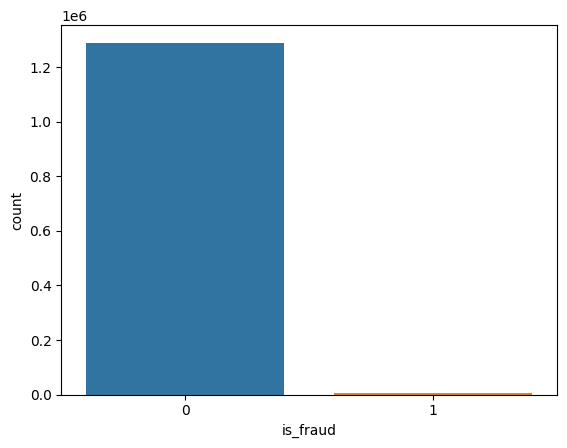

In [ ]:
neg = df["is_fraud"].value_counts()[0]
pos = df["is_fraud"].value_counts()[1]
print(neg, pos)
sns.countplot(data=df, x="is_fraud")

### Prepare Data

#### Set Column Types

In [ ]:
# CC Number
if ID_cust == True:
    df["cc_num"] = df["cc_num"].astype("category")
else:
    df.drop(columns={"cc_num"}, inplace=True)

In [ ]:
# Job
if ID_job == True:
    df["job"] = df["job"].astype("category")
else:
    df.drop(columns={"job"}, inplace=True)

In [ ]:
# Merchant
if ID_merch == True:
    df["merchant"] = df["merchant"].astype("category")
else:
    df.drop(columns={"merchant"}, inplace=True)

#### Ensure Categorical is Categorical

In [ ]:
df["Time"] = df["Time"].astype("category")
df["category"] = df["category"].astype("category")
df["gender"] = df["gender"].astype("category")
df["state"] = df["state"].astype("category")
df["is_fraud"] = df["is_fraud"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   category        1296675 non-null  category
 1   amt             1296675 non-null  float64 
 2   gender          1296675 non-null  category
 3   state           1296675 non-null  category
 4   city_pop        1296675 non-null  int64   
 5   job             1296675 non-null  category
 6   is_fraud        1296675 non-null  int64   
 7   dist_from_home  1296675 non-null  float64 
 8   Time            1296675 non-null  category
 9   recency         1296675 non-null  float64 
 10  year_born       1296675 non-null  int32   
dtypes: category(5), float64(3), int32(1), int64(2)
memory usage: 61.9 MB


In [ ]:
y = np.array(df["is_fraud"]).reshape(-1, 1)
df_dum = pd.get_dummies(df.drop(columns={"is_fraud"}))
#df_dum = pd.get_dummies(df)
#df_dum.to_csv(df_file, index=False)
X = np.array(df_dum)
#X_cols = df_dum.drop(columns={"is_fraud"}).columns
inp_shape = X.shape[1]
print(X.shape, y.shape)

(1296675, 591) (1296675, 1)


### Split Data

Train/test split is slow for this much data. For testing we can do an index based split. This saves massive amounts of time in processing and testing when doing trials. 

In [ ]:
if test_split:
    X_train = X[split_num:]
    X_test = X[:split_num]
    y_train = y[split_num:]
    y_test = y[:split_num]
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1096675, 591) (1096675, 1)
(200000, 591) (200000, 1)
[]


### Oversample

We can add oversampling. 

In [ ]:
from imblearn.over_sampling import SMOTE

#ros = RandomOverSampler()
ros = SMOTE()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_train_resampled = X_train_resampled.astype("float32")
y_train_resampled = y_train_resampled.astype("float32")

print(X_train_resampled.shape, y_train_resampled.shape)


### Model

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.F1Score(name='f1'),
      keras.metrics.AUC(name='auc'),
]

#Set Bias
bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(bias)

normalizer = tf.keras.layers.Normalization(axis=-1)

mask = np.random.choice([False, True], len(X_train), p=[0.75, 0.25])
normalizer.adapt(np.array(X_train[mask]).astype(np.float32))

#Build Model 
model = Sequential()
model.add(keras.layers.Input(shape=(inp_shape,)))
model.add(normalizer)
model.add(Dense(flat_layer_size, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(reg_ratio)))
model.add(Dense(flat_layer_size, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(reg_ratio)))
model.add(Dropout(drop_ratio))

model.add(Dense(flat_layer_size, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(reg_ratio)))
model.add(Dense(flat_layer_size, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(reg_ratio)))
model.add(Dropout(drop_ratio))
#model.add(Dense(flat_layer_size, activation='leaky_relu'))
#model.add(Dropout(0.3))
model.add(Dense(flat_layer_size/3, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(reg_ratio)))
model.add(Dense(flat_layer_size/3, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(reg_ratio)))

#model.add(Dropout(drop_ratio))
model.add(Dense(1, activation='sigmoid',bias_initializer=output_bias),)
model.summary()

model.compile(
  optimizer=tf.optimizers.Adam(),
  loss=keras.losses.BinaryCrossentropy(),
  metrics=METRICS
)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_12                │ (None, 256, 590)       │         1,183 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256, 591)       │       349,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256, 591)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256, 591)       │       349,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256, 591)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256, 1)         │           592 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,928 (2.67 MB)

 Trainable params: 699,745 (2.67 MB)

 Non-trainable params: 1,183 (4.62 KB)

In [ ]:
# Plots
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_acc(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
inp_shape

591

##### Class Weights

In [ ]:
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
    verbose=1, patience=cb_epochs, restore_best_weights=True)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
#train_log = model.fit(X_train, y_train, 
train_log = model.fit(X_train_resampled, y_train_resampled,
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_split=.3, 
                      verbose=1, 
                      callbacks=[early_stopping],
                      class_weight=class_weight,
                      )
#train_log = model.fit(train_ds, epochs=epochs, verbose=1, callbacks=[early_stopping], validation_data=val_ds)
# Save Weights
model.save_weights("model_weights.keras")
plot_loss(train_log)
plot_acc(train_log)
print(model.evaluate(X_test, y_test))

Epoch 1/10


KeyError: 'Exception encountered when calling Sequential.call().\n\n\x1b[1minput_layer_12\x1b[0m\n\nArguments received by Sequential.call():\n  • inputs=OrderedDict([(\'amt\', \'tf.Tensor(shape=(590,), dtype=float32)\'), (\'city_pop\', \'tf.Tensor(shape=(590,), dtype=int32)\'), (\'dist_from_home\', \'tf.Tensor(shape=(590,), dtype=float32)\'), (\'recency\', \'tf.Tensor(shape=(590,), dtype=float32)\'), (\'year_born\', \'tf.Tensor(shape=(590,), dtype=int32)\'), (\'category_entertainment\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_food_dining\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_gas_transport\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_grocery_net\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_grocery_pos\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_health_fitness\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_home\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_kids_pets\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_misc_net\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_misc_pos\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_personal_care\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_shopping_net\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_shopping_pos\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'category_travel\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'gender_F\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'gender_M\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_AK\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_AL\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_AR\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_AZ\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_CA\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_CO\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_CT\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_DC\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_DE\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_FL\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_GA\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_HI\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_IA\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_ID\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_IL\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_IN\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_KS\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_KY\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_LA\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_MA\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_MD\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_ME\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_MI\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_MN\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_MO\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_MS\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_MT\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_NC\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_ND\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_NE\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_NH\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_NJ\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_NM\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_NV\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_NY\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_OH\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_OK\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_OR\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_PA\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_RI\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_SC\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_SD\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_TN\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_TX\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_UT\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_VA\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_VT\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_WA\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_WI\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_WV\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'state_WY\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Academic librarian\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Accountant, chartered\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Accountant, chartered certified\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Accountant, chartered public finance\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Accounting technician\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Acupuncturist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Administrator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Administrator, arts\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Administrator, charities/voluntary organisations\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Administrator, education\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Administrator, local government\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Advertising account executive\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Advertising account planner\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Advertising copywriter\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Advice worker\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Aeronautical engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Agricultural consultant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Aid worker\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Air broker\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Air cabin crew\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Air traffic controller\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Airline pilot\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Ambulance person\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Amenity horticulturist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Analytical chemist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Animal nutritionist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Animal technologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Animator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Applications developer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Arboriculturist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Archaeologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Architect\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Architectural technologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Archivist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Armed forces logistics/support/administrative officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Armed forces technical officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Armed forces training and education officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Art gallery manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Art therapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Artist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Arts development officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Associate Professor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Audiological scientist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Barista\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Barrister\', \'tf.Tensor(shape=(590,), dtype=string)\'), ("job_Barrister\'s clerk", \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Biochemist, clinical\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Biomedical engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Biomedical scientist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Bookseller\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Broadcast engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Broadcast journalist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Broadcast presenter\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Building control surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Building services engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Building surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Buyer, industrial\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Buyer, retail\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Cabin crew\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Call centre manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Camera operator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Careers adviser\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Careers information officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Cartographer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Catering manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Ceramics designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Charity fundraiser\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Charity officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chartered accountant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chartered legal executive (England and Wales)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chartered loss adjuster\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chartered public finance accountant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chemical engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chemist, analytical\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chief Executive Officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chief Financial Officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chief Marketing Officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chief Operating Officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chief Strategy Officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chief Technology Officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chief of Staff\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Child psychotherapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Chiropodist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Civil Service administrator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Civil Service fast streamer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Civil engineer, contracting\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Claims inspector/assessor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Clinical biochemist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Clinical cytogeneticist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Clinical psychologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Clinical research associate\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Clothing/textile technologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Colour technologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Commercial horticulturist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Commercial/residential surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Commissioning editor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Communications engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Community arts worker\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Community development worker\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Community education officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Community pharmacist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Company secretary\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Comptroller\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Conservation officer, historic buildings\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Conservator, furniture\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Conservator, museum/gallery\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Contracting civil engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Contractor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Control and instrumentation engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Copy\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Copywriter, advertising\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Corporate investment banker\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Counselling psychologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Counsellor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Curator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Cytogeneticist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Dance movement psychotherapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Dancer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Data scientist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Database administrator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Dealer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Designer, ceramics/pottery\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Designer, exhibition/display\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Designer, furniture\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Designer, industrial/product\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Designer, interior/spatial\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Designer, jewellery\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Designer, multimedia\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Designer, television/film set\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Designer, textile\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Development worker, community\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Development worker, international aid\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Diagnostic radiographer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Dispensing optician\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Doctor, general practice\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Doctor, hospital\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Drilling engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Early years teacher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Ecologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Economist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Editor, commissioning\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Editor, film/video\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Editor, magazine features\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Education administrator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Education officer, community\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Education officer, museum\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Educational psychologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Electrical engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Electronics engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Embryologist, clinical\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Emergency planning/management officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Energy engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Energy manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, aeronautical\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, agricultural\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, automotive\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, biomedical\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, broadcasting (operations)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, building services\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, civil (consulting)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, civil (contracting)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, communications\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, control and instrumentation\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, drilling\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, electronics\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, land\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, maintenance\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, manufacturing\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, materials\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, mining\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, petroleum\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, production\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, site\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, structural\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineer, technical sales\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Engineering geologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_English as a foreign language teacher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_English as a second language teacher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Environmental consultant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Environmental education officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Environmental health practitioner\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Environmental manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Equality and diversity officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Equities trader\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Estate manager/land agent\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Event organiser\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Exercise physiologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Exhibition designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Exhibitions officer, museum/gallery\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Facilities manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Farm manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Field seismologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Field trials officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Film/video editor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Financial adviser\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Financial trader\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Fine artist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Firefighter\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Fisheries officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Fitness centre manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Forensic psychologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Forest/woodland manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Freight forwarder\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Furniture conservator/restorer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Furniture designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Further education lecturer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Futures trader\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Gaffer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Garment/textile technologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_General practice doctor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Geneticist, molecular\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Geochemist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Geologist, engineering\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Geologist, wellsite\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Geophysicist/field seismologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Geoscientist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Glass blower/designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Health and safety adviser\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Health physicist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Health promotion specialist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Health service manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Health visitor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Herbalist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Heritage manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Herpetologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Higher education careers adviser\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Historic buildings inspector/conservation officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Homeopath\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Horticultural consultant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Horticultural therapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Horticulturist, commercial\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Hospital doctor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Hospital pharmacist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Hotel manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Human resources officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Hydrogeologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Hydrographic surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Hydrologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_IT consultant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_IT trainer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Illustrator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Immigration officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Immunologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Industrial buyer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Industrial/product designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Information officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Information systems manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Insurance broker\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Insurance claims handler\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Insurance risk surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Insurance underwriter\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Intelligence analyst\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Interior and spatial designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Interpreter\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Investment analyst\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Investment banker, corporate\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Investment banker, operational\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Jewellery designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Journalist, newspaper\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Land\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Land/geomatics surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Landscape architect\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Lawyer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Learning disability nurse\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Learning mentor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Lecturer, further education\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Lecturer, higher education\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Legal secretary\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Leisure centre manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Lexicographer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Librarian, academic\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Librarian, public\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Licensed conveyancer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Local government officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Location manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Logistics and distribution manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Loss adjuster, chartered\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Magazine features editor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Magazine journalist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Maintenance engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Make\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Management consultant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Manufacturing engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Manufacturing systems engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Market researcher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Marketing executive\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Materials engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Mechanical engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Media buyer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Media planner\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Medical physicist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Medical sales representative\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Medical secretary\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Medical technical officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Mental health nurse\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Merchandiser, retail\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Metallurgist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Minerals surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Mining engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Mudlogger\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Multimedia programmer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Museum education officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Museum/gallery conservator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Museum/gallery exhibitions officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Music therapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Music tutor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Musician\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Nature conservation officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Naval architect\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Network engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Neurosurgeon\', \'tf.Tensor(shape=(590,), dtype=string)\'), ("job_Nurse, children\'s", \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Nurse, mental health\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Nutritional therapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Occupational hygienist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Occupational psychologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Occupational therapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Oceanographer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Oncologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Operational researcher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Operations geologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Optician, dispensing\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Optometrist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Orthoptist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Osteopath\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Outdoor activities/education manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Paediatric nurse\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Paramedic\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Patent attorney\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Pathologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Pension scheme manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Pensions consultant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Personnel officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Petroleum engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Pharmacist, community\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Pharmacist, hospital\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Pharmacologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Physicist, medical\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Physiological scientist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Physiotherapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Phytotherapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Pilot, airline\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Planning and development surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Plant breeder/geneticist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Podiatrist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Police officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), ("job_Politician\'s assistant", \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Presenter, broadcasting\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Press photographer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Press sub\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Primary school teacher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Prison officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Private music teacher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Probation officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Producer, radio\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Producer, television/film/video\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Product designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Product manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Product/process development scientist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Production assistant, radio\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Production assistant, television\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Production engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Production manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Professor Emeritus\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Programme researcher, broadcasting/film/video\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Programmer, applications\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Programmer, multimedia\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Psychiatric nurse\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Psychiatrist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Psychologist, clinical\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Psychologist, counselling\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Psychologist, forensic\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Psychologist, sport and exercise\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Psychotherapist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Psychotherapist, child\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Public affairs consultant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Public house manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Public librarian\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Public relations account executive\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Public relations officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Purchasing manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Quantity surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Quarry manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Race relations officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Radio broadcast assistant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Radio producer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Radiographer, diagnostic\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Radiographer, therapeutic\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Records manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Regulatory affairs officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Research officer, political party\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Research officer, trade union\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Research scientist (life sciences)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Research scientist (maths)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Research scientist (medical)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Research scientist (physical sciences)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Restaurant manager, fast food\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Retail banker\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Retail buyer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Retail manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Retail merchandiser\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Risk analyst\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Rural practice surveyor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Sales executive\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Sales professional, IT\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Sales promotion account executive\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Science writer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Scientific laboratory technician\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Scientist, audiological\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Scientist, biomedical\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Scientist, clinical (histocompatibility and immunogenetics)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Scientist, marine\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Scientist, physiological\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Scientist, research (maths)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Scientist, research (medical)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Scientist, research (physical sciences)\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Secondary school teacher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Secretary/administrator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Seismic interpreter\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Senior tax professional/tax inspector\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Set designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Ship broker\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Site engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Social research officer, government\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Social researcher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Soil scientist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Solicitor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Solicitor, Scotland\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Special educational needs teacher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Special effects artist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Sport and exercise psychologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Sports administrator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Sports development officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Stage manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Statistician\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Structural engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Sub\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Surgeon\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Surveyor, hydrographic\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Surveyor, land/geomatics\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Surveyor, minerals\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Surveyor, mining\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Surveyor, rural practice\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Systems analyst\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Systems developer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_TEFL teacher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Tax adviser\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Tax inspector\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Teacher, English as a foreign language\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Teacher, adult education\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Teacher, early years/pre\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Teacher, primary school\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Teacher, secondary school\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Teacher, special educational needs\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Teaching laboratory technician\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Technical brewer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Telecommunications researcher\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Television camera operator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Television floor manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Television production assistant\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Television/film/video producer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Textile designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Theatre director\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Theatre manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Theme park manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Therapist, art\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Therapist, drama\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Therapist, horticultural\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Therapist, music\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Therapist, occupational\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Therapist, sports\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Tour manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Tourism officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Tourist information centre manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Town planner\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Toxicologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Trade mark attorney\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Trading standards officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Training and development officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Transport planner\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Travel agency manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Tree surgeon\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Veterinary surgeon\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Video editor\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Visual merchandiser\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Volunteer coordinator\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Warden/ranger\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Warehouse manager\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Waste management officer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Water engineer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Water quality scientist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Web designer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Wellsite geologist\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'job_Writer\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_0\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_1\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_2\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_3\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_4\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_5\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_6\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_7\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_8\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_9\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_10\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_11\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_12\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_13\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_14\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_15\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_16\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_17\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_18\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_19\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_20\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_21\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_22\', \'tf.Tensor(shape=(590,), dtype=string)\'), (\'Time_23\', \'tf.Tensor(shape=(590,), dtype=string)\')])\n  • training=True\n  • mask=OrderedDict([(\'amt\', \'None\'), (\'city_pop\', \'None\'), (\'dist_from_home\', \'None\'), (\'recency\', \'None\'), (\'year_born\', \'None\'), (\'category_entertainment\', \'None\'), (\'category_food_dining\', \'None\'), (\'category_gas_transport\', \'None\'), (\'category_grocery_net\', \'None\'), (\'category_grocery_pos\', \'None\'), (\'category_health_fitness\', \'None\'), (\'category_home\', \'None\'), (\'category_kids_pets\', \'None\'), (\'category_misc_net\', \'None\'), (\'category_misc_pos\', \'None\'), (\'category_personal_care\', \'None\'), (\'category_shopping_net\', \'None\'), (\'category_shopping_pos\', \'None\'), (\'category_travel\', \'None\'), (\'gender_F\', \'None\'), (\'gender_M\', \'None\'), (\'state_AK\', \'None\'), (\'state_AL\', \'None\'), (\'state_AR\', \'None\'), (\'state_AZ\', \'None\'), (\'state_CA\', \'None\'), (\'state_CO\', \'None\'), (\'state_CT\', \'None\'), (\'state_DC\', \'None\'), (\'state_DE\', \'None\'), (\'state_FL\', \'None\'), (\'state_GA\', \'None\'), (\'state_HI\', \'None\'), (\'state_IA\', \'None\'), (\'state_ID\', \'None\'), (\'state_IL\', \'None\'), (\'state_IN\', \'None\'), (\'state_KS\', \'None\'), (\'state_KY\', \'None\'), (\'state_LA\', \'None\'), (\'state_MA\', \'None\'), (\'state_MD\', \'None\'), (\'state_ME\', \'None\'), (\'state_MI\', \'None\'), (\'state_MN\', \'None\'), (\'state_MO\', \'None\'), (\'state_MS\', \'None\'), (\'state_MT\', \'None\'), (\'state_NC\', \'None\'), (\'state_ND\', \'None\'), (\'state_NE\', \'None\'), (\'state_NH\', \'None\'), (\'state_NJ\', \'None\'), (\'state_NM\', \'None\'), (\'state_NV\', \'None\'), (\'state_NY\', \'None\'), (\'state_OH\', \'None\'), (\'state_OK\', \'None\'), (\'state_OR\', \'None\'), (\'state_PA\', \'None\'), (\'state_RI\', \'None\'), (\'state_SC\', \'None\'), (\'state_SD\', \'None\'), (\'state_TN\', \'None\'), (\'state_TX\', \'None\'), (\'state_UT\', \'None\'), (\'state_VA\', \'None\'), (\'state_VT\', \'None\'), (\'state_WA\', \'None\'), (\'state_WI\', \'None\'), (\'state_WV\', \'None\'), (\'state_WY\', \'None\'), (\'job_Academic librarian\', \'None\'), (\'job_Accountant, chartered\', \'None\'), (\'job_Accountant, chartered certified\', \'None\'), (\'job_Accountant, chartered public finance\', \'None\'), (\'job_Accounting technician\', \'None\'), (\'job_Acupuncturist\', \'None\'), (\'job_Administrator\', \'None\'), (\'job_Administrator, arts\', \'None\'), (\'job_Administrator, charities/voluntary organisations\', \'None\'), (\'job_Administrator, education\', \'None\'), (\'job_Administrator, local government\', \'None\'), (\'job_Advertising account executive\', \'None\'), (\'job_Advertising account planner\', \'None\'), (\'job_Advertising copywriter\', \'None\'), (\'job_Advice worker\', \'None\'), (\'job_Aeronautical engineer\', \'None\'), (\'job_Agricultural consultant\', \'None\'), (\'job_Aid worker\', \'None\'), (\'job_Air broker\', \'None\'), (\'job_Air cabin crew\', \'None\'), (\'job_Air traffic controller\', \'None\'), (\'job_Airline pilot\', \'None\'), (\'job_Ambulance person\', \'None\'), (\'job_Amenity horticulturist\', \'None\'), (\'job_Analytical chemist\', \'None\'), (\'job_Animal nutritionist\', \'None\'), (\'job_Animal technologist\', \'None\'), (\'job_Animator\', \'None\'), (\'job_Applications developer\', \'None\'), (\'job_Arboriculturist\', \'None\'), (\'job_Archaeologist\', \'None\'), (\'job_Architect\', \'None\'), (\'job_Architectural technologist\', \'None\'), (\'job_Archivist\', \'None\'), (\'job_Armed forces logistics/support/administrative officer\', \'None\'), (\'job_Armed forces technical officer\', \'None\'), (\'job_Armed forces training and education officer\', \'None\'), (\'job_Art gallery manager\', \'None\'), (\'job_Art therapist\', \'None\'), (\'job_Artist\', \'None\'), (\'job_Arts development officer\', \'None\'), (\'job_Associate Professor\', \'None\'), (\'job_Audiological scientist\', \'None\'), (\'job_Barista\', \'None\'), (\'job_Barrister\', \'None\'), ("job_Barrister\'s clerk", \'None\'), (\'job_Biochemist, clinical\', \'None\'), (\'job_Biomedical engineer\', \'None\'), (\'job_Biomedical scientist\', \'None\'), (\'job_Bookseller\', \'None\'), (\'job_Broadcast engineer\', \'None\'), (\'job_Broadcast journalist\', \'None\'), (\'job_Broadcast presenter\', \'None\'), (\'job_Building control surveyor\', \'None\'), (\'job_Building services engineer\', \'None\'), (\'job_Building surveyor\', \'None\'), (\'job_Buyer, industrial\', \'None\'), (\'job_Buyer, retail\', \'None\'), (\'job_Cabin crew\', \'None\'), (\'job_Call centre manager\', \'None\'), (\'job_Camera operator\', \'None\'), (\'job_Careers adviser\', \'None\'), (\'job_Careers information officer\', \'None\'), (\'job_Cartographer\', \'None\'), (\'job_Catering manager\', \'None\'), (\'job_Ceramics designer\', \'None\'), (\'job_Charity fundraiser\', \'None\'), (\'job_Charity officer\', \'None\'), (\'job_Chartered accountant\', \'None\'), (\'job_Chartered legal executive (England and Wales)\', \'None\'), (\'job_Chartered loss adjuster\', \'None\'), (\'job_Chartered public finance accountant\', \'None\'), (\'job_Chemical engineer\', \'None\'), (\'job_Chemist, analytical\', \'None\'), (\'job_Chief Executive Officer\', \'None\'), (\'job_Chief Financial Officer\', \'None\'), (\'job_Chief Marketing Officer\', \'None\'), (\'job_Chief Operating Officer\', \'None\'), (\'job_Chief Strategy Officer\', \'None\'), (\'job_Chief Technology Officer\', \'None\'), (\'job_Chief of Staff\', \'None\'), (\'job_Child psychotherapist\', \'None\'), (\'job_Chiropodist\', \'None\'), (\'job_Civil Service administrator\', \'None\'), (\'job_Civil Service fast streamer\', \'None\'), (\'job_Civil engineer, contracting\', \'None\'), (\'job_Claims inspector/assessor\', \'None\'), (\'job_Clinical biochemist\', \'None\'), (\'job_Clinical cytogeneticist\', \'None\'), (\'job_Clinical psychologist\', \'None\'), (\'job_Clinical research associate\', \'None\'), (\'job_Clothing/textile technologist\', \'None\'), (\'job_Colour technologist\', \'None\'), (\'job_Commercial horticulturist\', \'None\'), (\'job_Commercial/residential surveyor\', \'None\'), (\'job_Commissioning editor\', \'None\'), (\'job_Communications engineer\', \'None\'), (\'job_Community arts worker\', \'None\'), (\'job_Community development worker\', \'None\'), (\'job_Community education officer\', \'None\'), (\'job_Community pharmacist\', \'None\'), (\'job_Company secretary\', \'None\'), (\'job_Comptroller\', \'None\'), (\'job_Conservation officer, historic buildings\', \'None\'), (\'job_Conservator, furniture\', \'None\'), (\'job_Conservator, museum/gallery\', \'None\'), (\'job_Contracting civil engineer\', \'None\'), (\'job_Contractor\', \'None\'), (\'job_Control and instrumentation engineer\', \'None\'), (\'job_Copy\', \'None\'), (\'job_Copywriter, advertising\', \'None\'), (\'job_Corporate investment banker\', \'None\'), (\'job_Counselling psychologist\', \'None\'), (\'job_Counsellor\', \'None\'), (\'job_Curator\', \'None\'), (\'job_Cytogeneticist\', \'None\'), (\'job_Dance movement psychotherapist\', \'None\'), (\'job_Dancer\', \'None\'), (\'job_Data scientist\', \'None\'), (\'job_Database administrator\', \'None\'), (\'job_Dealer\', \'None\'), (\'job_Designer, ceramics/pottery\', \'None\'), (\'job_Designer, exhibition/display\', \'None\'), (\'job_Designer, furniture\', \'None\'), (\'job_Designer, industrial/product\', \'None\'), (\'job_Designer, interior/spatial\', \'None\'), (\'job_Designer, jewellery\', \'None\'), (\'job_Designer, multimedia\', \'None\'), (\'job_Designer, television/film set\', \'None\'), (\'job_Designer, textile\', \'None\'), (\'job_Development worker, community\', \'None\'), (\'job_Development worker, international aid\', \'None\'), (\'job_Diagnostic radiographer\', \'None\'), (\'job_Dispensing optician\', \'None\'), (\'job_Doctor, general practice\', \'None\'), (\'job_Doctor, hospital\', \'None\'), (\'job_Drilling engineer\', \'None\'), (\'job_Early years teacher\', \'None\'), (\'job_Ecologist\', \'None\'), (\'job_Economist\', \'None\'), (\'job_Editor, commissioning\', \'None\'), (\'job_Editor, film/video\', \'None\'), (\'job_Editor, magazine features\', \'None\'), (\'job_Education administrator\', \'None\'), (\'job_Education officer, community\', \'None\'), (\'job_Education officer, museum\', \'None\'), (\'job_Educational psychologist\', \'None\'), (\'job_Electrical engineer\', \'None\'), (\'job_Electronics engineer\', \'None\'), (\'job_Embryologist, clinical\', \'None\'), (\'job_Emergency planning/management officer\', \'None\'), (\'job_Energy engineer\', \'None\'), (\'job_Energy manager\', \'None\'), (\'job_Engineer, aeronautical\', \'None\'), (\'job_Engineer, agricultural\', \'None\'), (\'job_Engineer, automotive\', \'None\'), (\'job_Engineer, biomedical\', \'None\'), (\'job_Engineer, broadcasting (operations)\', \'None\'), (\'job_Engineer, building services\', \'None\'), (\'job_Engineer, civil (consulting)\', \'None\'), (\'job_Engineer, civil (contracting)\', \'None\'), (\'job_Engineer, communications\', \'None\'), (\'job_Engineer, control and instrumentation\', \'None\'), (\'job_Engineer, drilling\', \'None\'), (\'job_Engineer, electronics\', \'None\'), (\'job_Engineer, land\', \'None\'), (\'job_Engineer, maintenance\', \'None\'), (\'job_Engineer, manufacturing\', \'None\'), (\'job_Engineer, materials\', \'None\'), (\'job_Engineer, mining\', \'None\'), (\'job_Engineer, petroleum\', \'None\'), (\'job_Engineer, production\', \'None\'), (\'job_Engineer, site\', \'None\'), (\'job_Engineer, structural\', \'None\'), (\'job_Engineer, technical sales\', \'None\'), (\'job_Engineering geologist\', \'None\'), (\'job_English as a foreign language teacher\', \'None\'), (\'job_English as a second language teacher\', \'None\'), (\'job_Environmental consultant\', \'None\'), (\'job_Environmental education officer\', \'None\'), (\'job_Environmental health practitioner\', \'None\'), (\'job_Environmental manager\', \'None\'), (\'job_Equality and diversity officer\', \'None\'), (\'job_Equities trader\', \'None\'), (\'job_Estate manager/land agent\', \'None\'), (\'job_Event organiser\', \'None\'), (\'job_Exercise physiologist\', \'None\'), (\'job_Exhibition designer\', \'None\'), (\'job_Exhibitions officer, museum/gallery\', \'None\'), (\'job_Facilities manager\', \'None\'), (\'job_Farm manager\', \'None\'), (\'job_Field seismologist\', \'None\'), (\'job_Field trials officer\', \'None\'), (\'job_Film/video editor\', \'None\'), (\'job_Financial adviser\', \'None\'), (\'job_Financial trader\', \'None\'), (\'job_Fine artist\', \'None\'), (\'job_Firefighter\', \'None\'), (\'job_Fisheries officer\', \'None\'), (\'job_Fitness centre manager\', \'None\'), (\'job_Forensic psychologist\', \'None\'), (\'job_Forest/woodland manager\', \'None\'), (\'job_Freight forwarder\', \'None\'), (\'job_Furniture conservator/restorer\', \'None\'), (\'job_Furniture designer\', \'None\'), (\'job_Further education lecturer\', \'None\'), (\'job_Futures trader\', \'None\'), (\'job_Gaffer\', \'None\'), (\'job_Garment/textile technologist\', \'None\'), (\'job_General practice doctor\', \'None\'), (\'job_Geneticist, molecular\', \'None\'), (\'job_Geochemist\', \'None\'), (\'job_Geologist, engineering\', \'None\'), (\'job_Geologist, wellsite\', \'None\'), (\'job_Geophysicist/field seismologist\', \'None\'), (\'job_Geoscientist\', \'None\'), (\'job_Glass blower/designer\', \'None\'), (\'job_Health and safety adviser\', \'None\'), (\'job_Health physicist\', \'None\'), (\'job_Health promotion specialist\', \'None\'), (\'job_Health service manager\', \'None\'), (\'job_Health visitor\', \'None\'), (\'job_Herbalist\', \'None\'), (\'job_Heritage manager\', \'None\'), (\'job_Herpetologist\', \'None\'), (\'job_Higher education careers adviser\', \'None\'), (\'job_Historic buildings inspector/conservation officer\', \'None\'), (\'job_Homeopath\', \'None\'), (\'job_Horticultural consultant\', \'None\'), (\'job_Horticultural therapist\', \'None\'), (\'job_Horticulturist, commercial\', \'None\'), (\'job_Hospital doctor\', \'None\'), (\'job_Hospital pharmacist\', \'None\'), (\'job_Hotel manager\', \'None\'), (\'job_Human resources officer\', \'None\'), (\'job_Hydrogeologist\', \'None\'), (\'job_Hydrographic surveyor\', \'None\'), (\'job_Hydrologist\', \'None\'), (\'job_IT consultant\', \'None\'), (\'job_IT trainer\', \'None\'), (\'job_Illustrator\', \'None\'), (\'job_Immigration officer\', \'None\'), (\'job_Immunologist\', \'None\'), (\'job_Industrial buyer\', \'None\'), (\'job_Industrial/product designer\', \'None\'), (\'job_Information officer\', \'None\'), (\'job_Information systems manager\', \'None\'), (\'job_Insurance broker\', \'None\'), (\'job_Insurance claims handler\', \'None\'), (\'job_Insurance risk surveyor\', \'None\'), (\'job_Insurance underwriter\', \'None\'), (\'job_Intelligence analyst\', \'None\'), (\'job_Interior and spatial designer\', \'None\'), (\'job_Interpreter\', \'None\'), (\'job_Investment analyst\', \'None\'), (\'job_Investment banker, corporate\', \'None\'), (\'job_Investment banker, operational\', \'None\'), (\'job_Jewellery designer\', \'None\'), (\'job_Journalist, newspaper\', \'None\'), (\'job_Land\', \'None\'), (\'job_Land/geomatics surveyor\', \'None\'), (\'job_Landscape architect\', \'None\'), (\'job_Lawyer\', \'None\'), (\'job_Learning disability nurse\', \'None\'), (\'job_Learning mentor\', \'None\'), (\'job_Lecturer, further education\', \'None\'), (\'job_Lecturer, higher education\', \'None\'), (\'job_Legal secretary\', \'None\'), (\'job_Leisure centre manager\', \'None\'), (\'job_Lexicographer\', \'None\'), (\'job_Librarian, academic\', \'None\'), (\'job_Librarian, public\', \'None\'), (\'job_Licensed conveyancer\', \'None\'), (\'job_Local government officer\', \'None\'), (\'job_Location manager\', \'None\'), (\'job_Logistics and distribution manager\', \'None\'), (\'job_Loss adjuster, chartered\', \'None\'), (\'job_Magazine features editor\', \'None\'), (\'job_Magazine journalist\', \'None\'), (\'job_Maintenance engineer\', \'None\'), (\'job_Make\', \'None\'), (\'job_Management consultant\', \'None\'), (\'job_Manufacturing engineer\', \'None\'), (\'job_Manufacturing systems engineer\', \'None\'), (\'job_Market researcher\', \'None\'), (\'job_Marketing executive\', \'None\'), (\'job_Materials engineer\', \'None\'), (\'job_Mechanical engineer\', \'None\'), (\'job_Media buyer\', \'None\'), (\'job_Media planner\', \'None\'), (\'job_Medical physicist\', \'None\'), (\'job_Medical sales representative\', \'None\'), (\'job_Medical secretary\', \'None\'), (\'job_Medical technical officer\', \'None\'), (\'job_Mental health nurse\', \'None\'), (\'job_Merchandiser, retail\', \'None\'), (\'job_Metallurgist\', \'None\'), (\'job_Minerals surveyor\', \'None\'), (\'job_Mining engineer\', \'None\'), (\'job_Mudlogger\', \'None\'), (\'job_Multimedia programmer\', \'None\'), (\'job_Museum education officer\', \'None\'), (\'job_Museum/gallery conservator\', \'None\'), (\'job_Museum/gallery exhibitions officer\', \'None\'), (\'job_Music therapist\', \'None\'), (\'job_Music tutor\', \'None\'), (\'job_Musician\', \'None\'), (\'job_Nature conservation officer\', \'None\'), (\'job_Naval architect\', \'None\'), (\'job_Network engineer\', \'None\'), (\'job_Neurosurgeon\', \'None\'), ("job_Nurse, children\'s", \'None\'), (\'job_Nurse, mental health\', \'None\'), (\'job_Nutritional therapist\', \'None\'), (\'job_Occupational hygienist\', \'None\'), (\'job_Occupational psychologist\', \'None\'), (\'job_Occupational therapist\', \'None\'), (\'job_Oceanographer\', \'None\'), (\'job_Oncologist\', \'None\'), (\'job_Operational researcher\', \'None\'), (\'job_Operations geologist\', \'None\'), (\'job_Optician, dispensing\', \'None\'), (\'job_Optometrist\', \'None\'), (\'job_Orthoptist\', \'None\'), (\'job_Osteopath\', \'None\'), (\'job_Outdoor activities/education manager\', \'None\'), (\'job_Paediatric nurse\', \'None\'), (\'job_Paramedic\', \'None\'), (\'job_Patent attorney\', \'None\'), (\'job_Pathologist\', \'None\'), (\'job_Pension scheme manager\', \'None\'), (\'job_Pensions consultant\', \'None\'), (\'job_Personnel officer\', \'None\'), (\'job_Petroleum engineer\', \'None\'), (\'job_Pharmacist, community\', \'None\'), (\'job_Pharmacist, hospital\', \'None\'), (\'job_Pharmacologist\', \'None\'), (\'job_Physicist, medical\', \'None\'), (\'job_Physiological scientist\', \'None\'), (\'job_Physiotherapist\', \'None\'), (\'job_Phytotherapist\', \'None\'), (\'job_Pilot, airline\', \'None\'), (\'job_Planning and development surveyor\', \'None\'), (\'job_Plant breeder/geneticist\', \'None\'), (\'job_Podiatrist\', \'None\'), (\'job_Police officer\', \'None\'), ("job_Politician\'s assistant", \'None\'), (\'job_Presenter, broadcasting\', \'None\'), (\'job_Press photographer\', \'None\'), (\'job_Press sub\', \'None\'), (\'job_Primary school teacher\', \'None\'), (\'job_Prison officer\', \'None\'), (\'job_Private music teacher\', \'None\'), (\'job_Probation officer\', \'None\'), (\'job_Producer, radio\', \'None\'), (\'job_Producer, television/film/video\', \'None\'), (\'job_Product designer\', \'None\'), (\'job_Product manager\', \'None\'), (\'job_Product/process development scientist\', \'None\'), (\'job_Production assistant, radio\', \'None\'), (\'job_Production assistant, television\', \'None\'), (\'job_Production engineer\', \'None\'), (\'job_Production manager\', \'None\'), (\'job_Professor Emeritus\', \'None\'), (\'job_Programme researcher, broadcasting/film/video\', \'None\'), (\'job_Programmer, applications\', \'None\'), (\'job_Programmer, multimedia\', \'None\'), (\'job_Psychiatric nurse\', \'None\'), (\'job_Psychiatrist\', \'None\'), (\'job_Psychologist, clinical\', \'None\'), (\'job_Psychologist, counselling\', \'None\'), (\'job_Psychologist, forensic\', \'None\'), (\'job_Psychologist, sport and exercise\', \'None\'), (\'job_Psychotherapist\', \'None\'), (\'job_Psychotherapist, child\', \'None\'), (\'job_Public affairs consultant\', \'None\'), (\'job_Public house manager\', \'None\'), (\'job_Public librarian\', \'None\'), (\'job_Public relations account executive\', \'None\'), (\'job_Public relations officer\', \'None\'), (\'job_Purchasing manager\', \'None\'), (\'job_Quantity surveyor\', \'None\'), (\'job_Quarry manager\', \'None\'), (\'job_Race relations officer\', \'None\'), (\'job_Radio broadcast assistant\', \'None\'), (\'job_Radio producer\', \'None\'), (\'job_Radiographer, diagnostic\', \'None\'), (\'job_Radiographer, therapeutic\', \'None\'), (\'job_Records manager\', \'None\'), (\'job_Regulatory affairs officer\', \'None\'), (\'job_Research officer, political party\', \'None\'), (\'job_Research officer, trade union\', \'None\'), (\'job_Research scientist (life sciences)\', \'None\'), (\'job_Research scientist (maths)\', \'None\'), (\'job_Research scientist (medical)\', \'None\'), (\'job_Research scientist (physical sciences)\', \'None\'), (\'job_Restaurant manager, fast food\', \'None\'), (\'job_Retail banker\', \'None\'), (\'job_Retail buyer\', \'None\'), (\'job_Retail manager\', \'None\'), (\'job_Retail merchandiser\', \'None\'), (\'job_Risk analyst\', \'None\'), (\'job_Rural practice surveyor\', \'None\'), (\'job_Sales executive\', \'None\'), (\'job_Sales professional, IT\', \'None\'), (\'job_Sales promotion account executive\', \'None\'), (\'job_Science writer\', \'None\'), (\'job_Scientific laboratory technician\', \'None\'), (\'job_Scientist, audiological\', \'None\'), (\'job_Scientist, biomedical\', \'None\'), (\'job_Scientist, clinical (histocompatibility and immunogenetics)\', \'None\'), (\'job_Scientist, marine\', \'None\'), (\'job_Scientist, physiological\', \'None\'), (\'job_Scientist, research (maths)\', \'None\'), (\'job_Scientist, research (medical)\', \'None\'), (\'job_Scientist, research (physical sciences)\', \'None\'), (\'job_Secondary school teacher\', \'None\'), (\'job_Secretary/administrator\', \'None\'), (\'job_Seismic interpreter\', \'None\'), (\'job_Senior tax professional/tax inspector\', \'None\'), (\'job_Set designer\', \'None\'), (\'job_Ship broker\', \'None\'), (\'job_Site engineer\', \'None\'), (\'job_Social research officer, government\', \'None\'), (\'job_Social researcher\', \'None\'), (\'job_Soil scientist\', \'None\'), (\'job_Solicitor\', \'None\'), (\'job_Solicitor, Scotland\', \'None\'), (\'job_Special educational needs teacher\', \'None\'), (\'job_Special effects artist\', \'None\'), (\'job_Sport and exercise psychologist\', \'None\'), (\'job_Sports administrator\', \'None\'), (\'job_Sports development officer\', \'None\'), (\'job_Stage manager\', \'None\'), (\'job_Statistician\', \'None\'), (\'job_Structural engineer\', \'None\'), (\'job_Sub\', \'None\'), (\'job_Surgeon\', \'None\'), (\'job_Surveyor, hydrographic\', \'None\'), (\'job_Surveyor, land/geomatics\', \'None\'), (\'job_Surveyor, minerals\', \'None\'), (\'job_Surveyor, mining\', \'None\'), (\'job_Surveyor, rural practice\', \'None\'), (\'job_Systems analyst\', \'None\'), (\'job_Systems developer\', \'None\'), (\'job_TEFL teacher\', \'None\'), (\'job_Tax adviser\', \'None\'), (\'job_Tax inspector\', \'None\'), (\'job_Teacher, English as a foreign language\', \'None\'), (\'job_Teacher, adult education\', \'None\'), (\'job_Teacher, early years/pre\', \'None\'), (\'job_Teacher, primary school\', \'None\'), (\'job_Teacher, secondary school\', \'None\'), (\'job_Teacher, special educational needs\', \'None\'), (\'job_Teaching laboratory technician\', \'None\'), (\'job_Technical brewer\', \'None\'), (\'job_Telecommunications researcher\', \'None\'), (\'job_Television camera operator\', \'None\'), (\'job_Television floor manager\', \'None\'), (\'job_Television production assistant\', \'None\'), (\'job_Television/film/video producer\', \'None\'), (\'job_Textile designer\', \'None\'), (\'job_Theatre director\', \'None\'), (\'job_Theatre manager\', \'None\'), (\'job_Theme park manager\', \'None\'), (\'job_Therapist, art\', \'None\'), (\'job_Therapist, drama\', \'None\'), (\'job_Therapist, horticultural\', \'None\'), (\'job_Therapist, music\', \'None\'), (\'job_Therapist, occupational\', \'None\'), (\'job_Therapist, sports\', \'None\'), (\'job_Tour manager\', \'None\'), (\'job_Tourism officer\', \'None\'), (\'job_Tourist information centre manager\', \'None\'), (\'job_Town planner\', \'None\'), (\'job_Toxicologist\', \'None\'), (\'job_Trade mark attorney\', \'None\'), (\'job_Trading standards officer\', \'None\'), (\'job_Training and development officer\', \'None\'), (\'job_Transport planner\', \'None\'), (\'job_Travel agency manager\', \'None\'), (\'job_Tree surgeon\', \'None\'), (\'job_Veterinary surgeon\', \'None\'), (\'job_Video editor\', \'None\'), (\'job_Visual merchandiser\', \'None\'), (\'job_Volunteer coordinator\', \'None\'), (\'job_Warden/ranger\', \'None\'), (\'job_Warehouse manager\', \'None\'), (\'job_Waste management officer\', \'None\'), (\'job_Water engineer\', \'None\'), (\'job_Water quality scientist\', \'None\'), (\'job_Web designer\', \'None\'), (\'job_Wellsite geologist\', \'None\'), (\'job_Writer\', \'None\'), (\'Time_0\', \'None\'), (\'Time_1\', \'None\'), (\'Time_2\', \'None\'), (\'Time_3\', \'None\'), (\'Time_4\', \'None\'), (\'Time_5\', \'None\'), (\'Time_6\', \'None\'), (\'Time_7\', \'None\'), (\'Time_8\', \'None\'), (\'Time_9\', \'None\'), (\'Time_10\', \'None\'), (\'Time_11\', \'None\'), (\'Time_12\', \'None\'), (\'Time_13\', \'None\'), (\'Time_14\', \'None\'), (\'Time_15\', \'None\'), (\'Time_16\', \'None\'), (\'Time_17\', \'None\'), (\'Time_18\', \'None\'), (\'Time_19\', \'None\'), (\'Time_20\', \'None\'), (\'Time_21\', \'None\'), (\'Time_22\', \'None\'), (\'Time_23\', \'None\')])'

In [ ]:
test_cutoffs = [.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]
test_preds = model.predict(X_test)
for cutoff in test_cutoffs:
    y_pred = (test_preds > cutoff).astype(int)
    print("Cutoff: ", cutoff)
    print("\tAccuracy: ", np.mean(y_pred == y_test))
    print("\tRecall: ", np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1))
    print("\tPrecision: ", np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1))

In [ ]:

print("Standard Cutoff:")
print("Test Accuracy: ", np.mean((test_preds > 0.5) == y_test))
sns.heatmap(confusion_matrix(y_test, test_preds > 0.5), annot=True, fmt='d')

### Results - Not Terrible, Not Amazing